In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import io
from scipy import linalg
from scipy import optimize

# Warmup: Least Squares with 2d synthetic data

We will start with a simple least squares example on synthetic data with the goal of visualization.

(a) Create a vector of inputs x with 101 regularly-spaced entries between 0 and 1. 

Create a vector of labels y = 1 + x + x*z, where z is drawn from the uniform distribution on the half open interval [0, 1).

In [4]:
#Todo: Part a
x = np.arange(0, 1, 1/101)
z = np.random.uniform(0, 1)
y = 1 + x + x*z

(b) Create a matrix A whose first column is the vector x above, and it's second column is the ones vector.

In [5]:
# TODO Part (b): Assemble matrix A
ones = np.ones(x.shape)
A = np.zeros(shape=(len(x), 2))
for i in range(len(x)):
    A[i][0] = x[i]
    A[i][1] = ones[i]

# turn y into a column vector
y = y[:, np.newaxis]

(c) Solve the ordinary least squares problem to obtain a vector w of coefficients.

In [6]:
# TODO: Part (c)
m, c = np.linalg.lstsq(A, y, rcond=None)[0]

(d) Plot the training data (x,y) as blue dots and the learned function as a red line

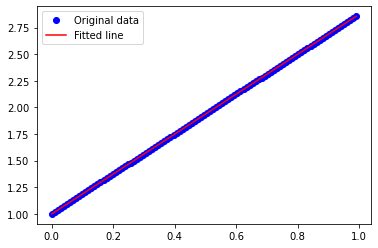

In [7]:
# TODO: Part (d)  
plt.plot(x, y, 'bo', label='Original data')
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.legend()
plt.show()

# System Identification

Making autonomous vehicles involves machine learning for different purposes. One of which is learning how cars actually behave based on their data.

**Setup for parts (a) and (b):** Assume that $x_t$ is the position of a car and obeys the following linear dynamics $$x_{t+1} = A^* x_t + B^* u_t $$

We do not know the matrices $A^*$ and $B^*$. But we have data about the cars position for timesteps $1 \ldots T$. We want to use this data to infer the underlying dynamics.

## Scalar Least Squares

First, we consider the simpler case where $x_t \in \mathbb{R}$ and $A^*, B^*$ are scalars as well.

(a) Consider the time sequence of scalars $x_t \in \mathbb{R}$ and $u_t \in \mathbb{R}$ in which $x_{t + 1} ≈ A x_t + B u_t$. In control theory, $x_t$ usually represents the state, and $u_t$ usually represents the control input. Find and output the numbers $A$ and $B$ so that $\sum_t (x_{t +1} − Ax_t − Bu_t)^2$ is minimized. The values of x_t and u_t are stored in a.mat.

In [160]:
mdict = scipy.io.loadmat("a.mat")
x = mdict['x']
u = mdict['u']

# TODO: Your code to compute a and b
def to_min(params):
    x = mdict['x']
    u = mdict['u']
    a, b = params
    sum = 0
    for j in range(len(x)):
        currx = x[j]
        curru = u[j]
        for i in range(len(currx)-1):
            val = 0
            val = currx[i+1] - a*currx[i] - b*curru[i]
            val = val**2
            sum += val
    return sum

ab = [1, 1]
res = optimize.minimize(to_min, ab, method='Nelder-Mead', tol=1e-6)
if(res.success):
    a = res.x[0]
    b = res.x[1]
    print(a)
    print(b)
else:
    print("Not successful")

0.977552086373869
-0.08775258815104042


## Matrix least squares

(b) Consider the time sequences of vectors $x_t \in \mathbb{R}^3$ and $u_t \in \mathbb{R}^3$ in which $x_{t + 1} ≈ Axt + But$ . Find and output the matrix $A \in \mathbb{R}^{3×3}$ and $B \in \mathbb{R}^{3×3}$ so that the sum of the squared $l_2$-norms of the error, 
$$\sum_t \| x_{t+1} − A x_t −B u_t \|_2^2 $$
is minimized. The values of x_t and u_t are stored in b.mat.

In [161]:
mdict = scipy.io.loadmat("b.mat")
x = mdict['x']
u = mdict['u']

# TODO: Your code to compute A, B
def to_min(params):
    x = mdict['x']
    u = mdict['u']
    A = params[0:3]
    B = params[3:6]
    sum = 0
    for i in range(len(x)-1):
        val = (x[i+1] - np.matmul(A, x[i]) - np.matmul(B, u[i]))
        normval = linalg.norm(val, ord=2)
        normval = normval**2
        sum += normval
    return sum

A = np.ones(9).reshape(3, 3)
B = np.ones(9).reshape(3, 3)
AB = np.concatenate([A, B])
res = optimize.minimize(to_min, AB, method='Nelder-Mead', tol=1e-6)
if(res.success):
    A = res.x[:9]
    B = res.x[9:]
    A = np.reshape(A, (3, 3))
    B = np.reshape(B, (3, 3))
    print(A)
    print(B)
else:
    print("Not successful")

[[-0.11150651  0.43282882  0.13433352]
 [ 0.30488788 -0.39806071 -0.36185384]
 [ 1.95641154  0.88992412  1.3492964 ]]
[[0.90341912 1.67571799 1.62979598]
 [1.27980238 2.16508706 0.66472806]
 [3.1361569  1.15292762 0.33912519]]


## Acceleration model

(c) Consider a car following model that models how cars line up on a straight 1D highway at a given time. The acceleration of a car can be approximated by a linear function of the positions and velocities of its own and the car in front of it. Mathematically, we can formulate this as

$$
\ddot{x}_{i} \approx a x_{i}+b \dot{x}_{i}+c x_{i-1}+d \dot{x}_{i-1}+e
$$

where $x_{i}, \dot{x}_{i}$, and $\ddot{x}_{i}$ are the position, velocity, and acceleration of the $i$ th car in the line.
Find $a, b, c, d$, and $e$ that minimize

$$
\sum_{i}\left\|-\ddot{x}_{i}+a x_{i}+b \dot{x}_{i}+c x_{i-1}+d \dot{x}_{i-1}+e\right\|_{2}^{2}
$$

using data file train. mat, which contains the status of 40000 cars at a given point from the I- 80 highway in California. The data were sampled from the Next Generation Simulation (NGSIM) dataset so that the $i$ may not be continuous. For your convenience, we give you the profiles of each sampled car and the car that is in front of it.

In [165]:
# TODO: Solve part (c)
# Your code to compute a, b, c, d, e
mdict = scipy.io.loadmat("train.mat")

def to_min(params):
    # Assemble xu matrix
    x = mdict["x"]   # position of a car
    v = mdict["xd"]  # velocity of the car
    xprev = mdict["xp"]   # position of the car ahead
    vprev = mdict["xdp"]  # velocity of the car ahead
    acc = mdict["xdd"]  # acceleration of the car

    a, b, c, d, e = params
    sum = 0
    for i in range(len(x)):
        loc = x[i]
        vel = v[i]
        locprev = xprev[i]
        velprev = vprev[i]
        accel = acc[i]
        
        val = -1*accel + a*loc + b*vel + c*locprev + d*velprev + e
        normval = linalg.norm(val, ord=2)
        normval = normval**2
        sum += normval
    return sum

a, b, c, d, e = 0, 0, 0, 0, 0
params = tuple([a, b, c, d, e])
res = optimize.minimize(to_min, params, method='Nelder-Mead', tol=1e-6)
if(res.success):
    a, b, c, d, e = res.x
    print("a: " + str(a))
    print("b: " + str(b))
    print("c: " + str(c))
    print("d: " + str(d))
    print("e: " + str(e))
else:
    print("Not successful")

a: -0.011521205542996463
b: -0.3177934187464643
c: 0.011289328531084464
d: 0.27535830141760675
e: -0.882935700781114
